This is my third post looking at the LOBSTER data set [published last year](https://doi.org/10.1007/s10822-024-00581-1) by the Rarey and BioSolveIT group. Here are links for [Part 1](https://greglandrum.github.io/rdkit-blog/posts/2025-11-08-working-with-lobster-1.html) and [Part 2](https://greglandrum.github.io/rdkit-blog/posts/2025-11-16-working-with-lobster-2.html).

This time I look at applying the different 3D alignment algorithms the RDKit includes to the data.

In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_3d = True

from matplotlib import pyplot as plt
plt.style.use('tableau-colorblind10')
plt.rcParams['font.size'] = '16'
%matplotlib inline

%load_ext sql
%config SqlMagic.feedback=0


In [10]:
import rdkit
print(rdkit.__version__)

2025.09.2


# Getting started

In [2]:
import lwreg
from lwreg import utils

Load our lwreg configuration from the database we created before:

In [3]:
config = utils.configure_from_database(dbname='lobster_112024',dbtype='postgresql')
lwreg.set_default_config(config)

config

{'dbname': 'lobster_112024',
 'dbtype': 'postgresql',
 'cacheConnection': True,
 'standardization': 'none',
 'removeHs': 1,
 'useTautomerHashv2': 0,
 'registerConformers': 1,
 'numConformerDigits': 3,
 'lwregSchema': ''}

Get a map from (nm,pdb) tuples to (molregno,confid,molblock):

In [6]:
d = %sql postgresql://localhost/lobster_112024 \
    select ligname,pdb,molregno,conf_id,molblock \
    from lobster_data.all_ligands join conformers using (molregno,conf_id);
ligs = {}
for nm,pdb,mrn,cid,mb in d:
    mol = Chem.MolFromMolBlock(mb,removeHs=False)
    mol_noh = Chem.MolFromMolBlock(mb)
    ligs[(nm,pdb.lower())] = (mrn,cid,mb,mol,mol_noh)

In [7]:
pairstats = %sql postgresql://localhost/lobster_112024 \
    select * from lobster_data.pair_stats
pairstats = list(pairstats.dicts())

In [9]:
from scipy import stats
def comparison_plot(pairstats,metric1,metric2,invert1=False,invert2=False,includeLine=False):
    x1 = [x[metric1] for x in pairstats]
    if invert1:
        x1 = [1-x for x in x1]
        metric1 = f'1-{metric1}'
    x2 = [x[metric2] for x in pairstats]
    if invert2:
        x2 = [1-x for x in x2]
        metric2 = f'1-{metric2}'
    r,_ = stats.spearmanr(x1,x2)
    tau,_ = stats.kendalltau(x1,x2)

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.scatter(x1,x2,alpha=0.5,s=5)
    if includeLine:
        plt.plot((0,1),(0,1),'k-')
    plt.xlabel(metric1)
    plt.ylabel(metric2)
    plt.title(f'rho={r:.2f}, tau={tau:.2f}');
    plt.subplot(1,2,2)
    plt.hexbin(x1,x2,cmap='Blues');
    plt.tight_layout()

# Comparing shape-similarity metrics in the LOBSTER data set

First let's look at the metrics in the LOBSTER data set:

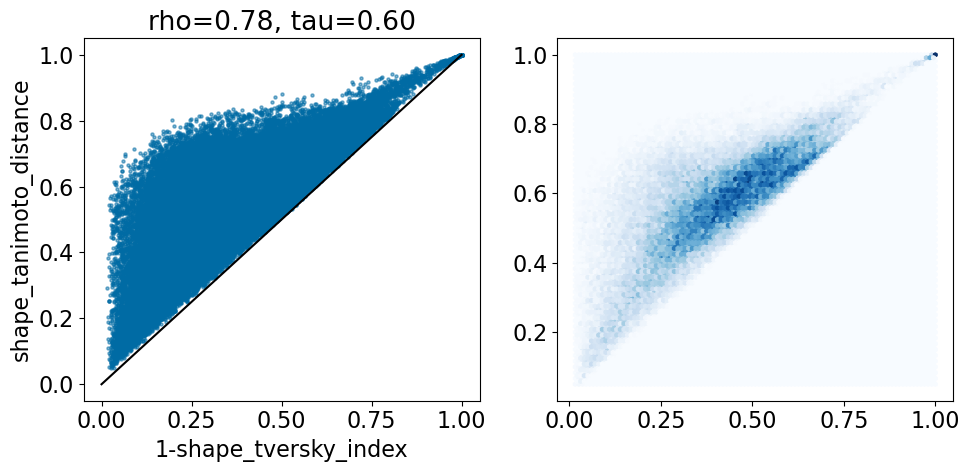

In [34]:
comparison_plot(pairstats,'shape_tversky_index','shape_tanimoto_distance',invert1=True,includeLine=True)


In the LOBSTER paper they use an asymmetric definition of the Tversky metric to detect how much of the template is covered by the probe. This yield small Tversky distances (large Tversky index values) when a small template is completely covered by a large probe. The Tanimoto distance, on the other hand, is symmetric, so it's always greater than 1-Tversky here.

And now the protrude distance, which looks at how much of the larger shape is *not* overlapping the smaller shape.

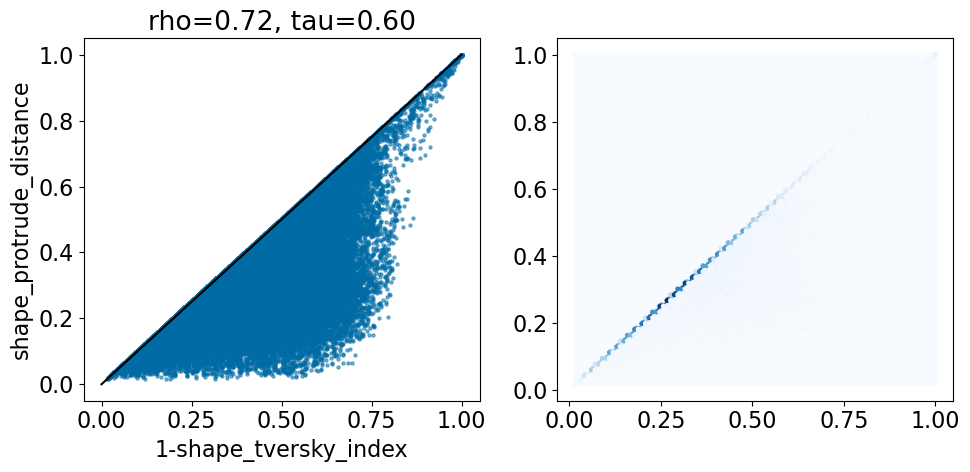

In [35]:
comparison_plot(pairstats,'shape_tversky_index','shape_protrude_distance',invert1=True,includeLine=True)


The protrude distance is, by default, symmetric: it is the fraction of the smaller of the two shapes that protrudes outside the larger of the two.

# Shape-based alignment

Let's see what we get when we perform shape-based alignment using the crystal conformers.

Start by aligning the crystal conformers.

In [45]:
from rdkit.Chem import rdShapeAlign
from rdkit.Chem import rdShapeHelpers
from rdkit.Chem import rdMolTransforms

from tqdm import tqdm
for d in tqdm(pairstats):
    m1 = Chem.Mol(ligs[(d['ligname1'],d['pdb1'])][3])
    m2 = Chem.Mol(ligs[(d['ligname2'],d['pdb2'])][3])
    rdMolTransforms.CanonicalizeConformer(m1.GetConformer())
    rdMolTransforms.CanonicalizeConformer(m2.GetConformer())
    
    st,ct = rdShapeAlign.AlignMol(m1,m2,opt_param=0.5)
    d['shape_align_ShapeTanimoto'] = st
    d['shape_align_ColorTanimoto'] = ct
    d['shape_align_ShapeTversky'] = rdShapeHelpers.ShapeTverskyIndex(m1,m2,0,1)
    



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 72592/72592 [01:15<00:00, 964.83it/s]


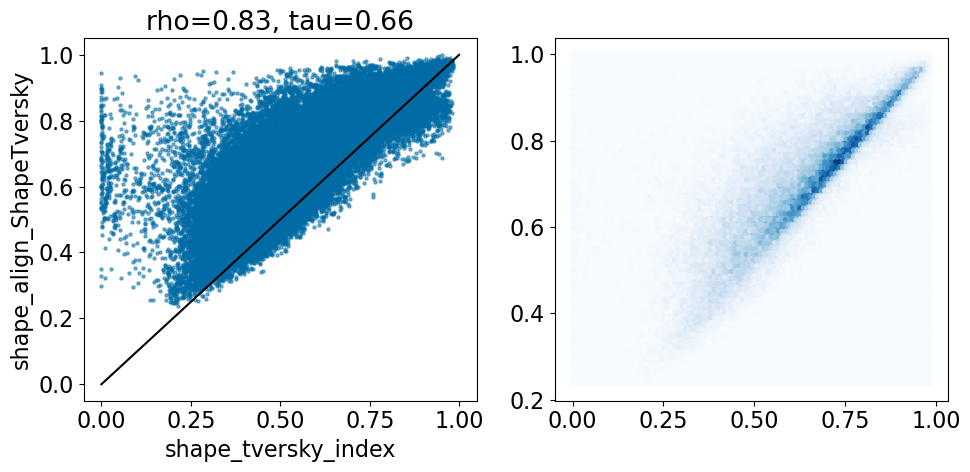

In [37]:
comparison_plot(pairstats,'shape_tversky_index','shape_align_ShapeTversky',invert1=False,invert2=False,
                includeLine=True)

Look at examples where the ShapeTversky in the shape alignment is significantly lower than that in the crystal alignment:

In [39]:
pruned = [r for r in pairstats if r['shape_tversky_index']>0.9 and r['shape_align_ShapeTversky']<0.8]
len(pruned)

79

In [40]:
d = pruned[0]
print((d['ligname1'],d['pdb1']),(d['ligname2'],d['pdb2']))
m1 = ligs[(d['ligname1'],d['pdb1'])][3]
m2 = ligs[(d['ligname2'],d['pdb2'])][3]
m1c = Chem.Mol(m1)
m2c = Chem.Mol(m2)
rdMolTransforms.CanonicalizeConformer(m1c.GetConformer())
rdMolTransforms.CanonicalizeConformer(m2c.GetConformer())
st,ct = rdShapeAlign.AlignMol(m1c,m2c,opt_param=0.5)
tversky = rdShapeHelpers.ShapeTverskyIndex(m1c,m2c,0,1)

print(st,ct)
print(d['shape_tversky_index'],tversky)


('1D1_A_401', '4i5p') ('11G_A_401', '4i6b')
0.6968245697702556 0.11721759959746417
0.951 0.7622862091361766


In [23]:
IPythonConsole.drawMols3D([m1,m2])

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [24]:
IPythonConsole.drawMols3D([m1c,m2c])

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

This is a case where the asymmetry of the Tversky Index used in the Lobster paper shows. Here in the crystal alignment the second of the two molecules is more or less completely contained within the first one; that leads to a very high Tversky index that drops significantly if we re-order the molecules:

In [25]:
tversky12 = rdShapeHelpers.ShapeTverskyIndex(m1,m2,0,1)
tversky21 = rdShapeHelpers.ShapeTverskyIndex(m2,m1,0,1)
print(f'{tversky12:.2f} -> {tversky21:.2f}')


0.95 -> 0.76


The shape alignment is symmetrical because it maximizes the overall overlap:

In [28]:
m1c = Chem.Mol(m1)
m2c = Chem.Mol(m2)
rdMolTransforms.CanonicalizeConformer(m1c.GetConformer())
rdMolTransforms.CanonicalizeConformer(m2c.GetConformer())
st2,ct2 = rdShapeAlign.AlignMol(m2c,m1c,opt_param=0.5)
tversky2 = rdShapeHelpers.ShapeTverskyIndex(m1c,m2c,0,1)

print(f'{tversky:.2f} -> {tversky2:.2f}')

0.76 -> 0.76


What about molecules with a very low crystal Tversky index and a high one from the shape alignment?

In [29]:
pruned = [r for r in pairstats if r['shape_tversky_index']<0.1 and r['shape_align_ShapeTversky']>0.8]
len(pruned)

42

In [30]:
d = pruned[0]
m1 = ligs[(d['ligname1'],d['pdb1'])][3]
m2 = ligs[(d['ligname2'],d['pdb2'])][3]
m1c = Chem.Mol(m1)
m2c = Chem.Mol(m2)
rdMolTransforms.CanonicalizeConformer(m1c.GetConformer())
rdMolTransforms.CanonicalizeConformer(m2c.GetConformer())
st,ct = rdShapeAlign.AlignMol(m1c,m2c,opt_param=0.5)
tversky = rdShapeHelpers.ShapeTverskyIndex(m1c,m2c,0,1)

print(st,ct)
print(d['shape_tversky_index'],tversky)


0.3489983628032094 0.08050058859625212
0.0 0.8264984227129337


In [31]:
IPythonConsole.drawMols3D([m1,m2])

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [32]:
IPythonConsole.drawMols3D([m1c,m2c])

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

This is a situation described in the LOBSTER paper: the crystal ligands are in very different parts of the pocket that was identified by SIENA.

We can figure out what's going on by looking at the PDB entries:

In [33]:
d

{'ligname1': 'N4Z_A_401',
 'pdb1': '6tel',
 'ligname2': '5JT_A_402',
 'pdb2': '5mw3',
 'ensemble': '5JU_A_401-5mw4',
 'morgan_fp_tanimoto': 0.115,
 'gobbi_2d_pharmacophore_fp_tanimoto': 0.102,
 'hac_difference': 29,
 'shape_tversky_index': 0.0,
 'shape_tanimoto_distance': 1.0,
 'shape_protrude_distance': 1.0,
 'shape_align_ShapeTanimoto': 0.3489983628032094,
 'shape_align_ColorTanimoto': 0.08050058859625212,
 'shape_align_ShapeTversky': 0.8264984227129337,
 'O3A_RMSD': 0.18706387903535077,
 'O3A_score': 99.22402124958128,
 'O3A_ShapeTversky': 0.6229205175600739,
 'CrippenO3A_RMSD': 0.3775024004623698,
 'CrippenO3A_score': 64.29333441352107,
 'CrippenO3A_ShapeTversky': 0.7638085218306154}

From looking at the PDBe pages for [ligand N4Z in 6tel](https://www.ebi.ac.uk/pdbe/entry/pdb/6tel?activeTab=ligands&id=N4Z) and [ligand 5JT in 5mw3](https://www.ebi.ac.uk/pdbe/entry/pdb/5mw3?activeTab=ligands&id=5JT) it looks like the automatic curation procedure for LOBSTER may have picked the wrong ligand for 5mw3 (which has two bound ligands), [ligand 5JJ](https://www.ebi.ac.uk/pdbe/entry/pdb/5mw3?activeTab=ligands&id=5JJ) looks like it may be a more similar pocket (or part of the pocket) to ligand N4Z.

# Open3DAlign

What about an alternative 3D alignment algorithm? Let's try aligning with Paolo Tosco's [Open3DAlign](https://link.springer.com/article/10.1007/s10822-011-9462-9):

In [ ]:
from rdkit.Chem import rdMolAlign

from tqdm import tqdm
for d in tqdm(pairstats):
    m1 = Chem.Mol(ligs[(d['ligname1'],d['pdb1'])][3])
    m2 = Chem.Mol(ligs[(d['ligname2'],d['pdb2'])][3])
    
    try:
        o3a = rdMolAlign.GetO3A(m2,m1)
        rmsd = o3a.Align()
        score = o3a.Score()
        tversky = rdShapeHelpers.ShapeTverskyIndex(m1,m2,0,1)
    except ValueError:
        # we get failures for molecules that don't have MMFF94 parameters.
        # set the results for those to zero
        rmsd = 0
        score = 0
        tversky = 0
    d['O3A_RMSD'] = rmsd
    d['O3A_score'] = score
    d['O3A_ShapeTversky'] = tversky
    



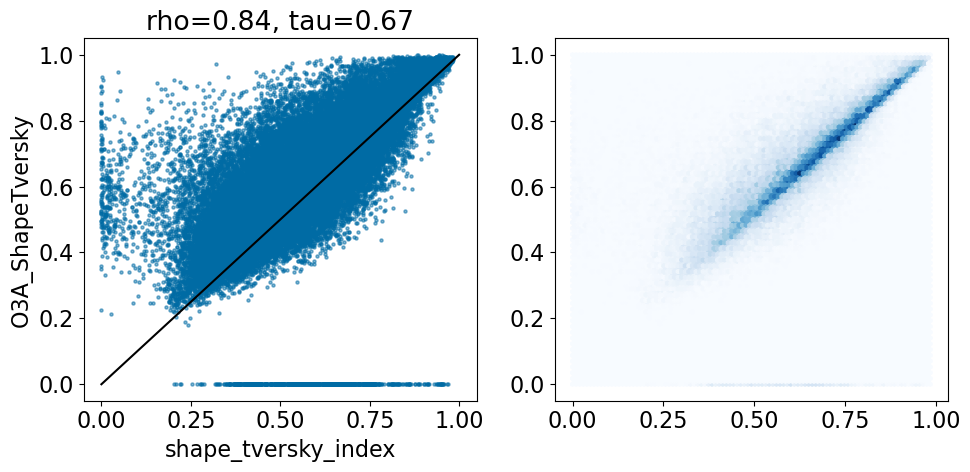

In [36]:
comparison_plot(pairstats,'shape_tversky_index','O3A_ShapeTversky',invert1=False,invert2=False,
                includeLine=True)

Ignoring the cases where Open3DAlign didn't have parameters, that's pretty similar to what we saw with the shape alignment, though there are points with a high Tversky index in the crystal structure and low Open3D align result.

In [42]:
ligname1,pdb1 = ('1D1_A_401', '4i5p') 
ligname2,pdb2 = ('11G_A_401', '4i6b')
d = pruned[0]
m1 = ligs[(ligname1,pdb1)][3]
m2 = ligs[(ligname2,pdb2)][3]
m1c = Chem.Mol(m1)
m2c = Chem.Mol(m2)
rdMolTransforms.CanonicalizeConformer(m1c.GetConformer())
rdMolTransforms.CanonicalizeConformer(m2c.GetConformer())
st,ct = rdShapeAlign.AlignMol(m1c,m2c,opt_param=0.5)
stversky = rdShapeHelpers.ShapeTverskyIndex(m1c,m2c,0,1)

m1c2 = Chem.Mol(m1)
m2c2 = Chem.Mol(m2)
o3a = rdMolAlign.GetO3A(m2c2,m1c2)
rmsd = o3a.Align()
o3atversky = rdShapeHelpers.ShapeTverskyIndex(m1c2,m2c2,0,1)

print(stversky,o3atversky)


0.7622862091361766 0.9846320346320346


The shape-based alignment (we saw this above):

In [43]:
IPythonConsole.drawMols3D([m1c,m2c])

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

And the Open3D alignment:

In [44]:
IPythonConsole.drawMols3D([m1c2,m2c2])

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Here we can see that Open3DAlign can quite happily align a smaller molecule to a larger one.

Directly compare the O3A results to the shape alignment results:

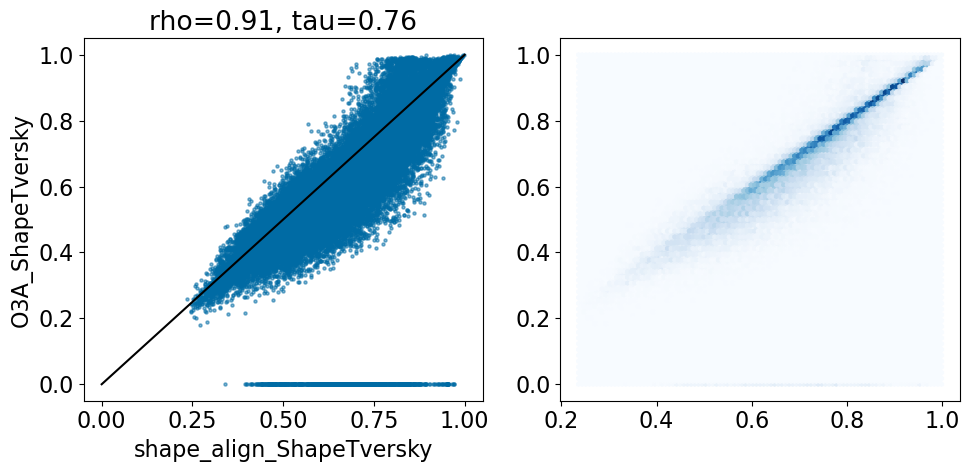

In [13]:
comparison_plot(pairstats,'shape_align_ShapeTversky','O3A_ShapeTversky',invert1=False,invert2=False,
                includeLine=True)

There's a reasonable number of pairs with high O3A similarities and low shape-align similarities. These are probably cases like we just saw: alignments of a small ligand to a larger one where there's a good feature overlap between the small and large structures.

Aside from the alignments that didn't work due to missing parameters (where the O3A Tversky is 0), the correlation is quite good

The RDKit has a variation on Open3DAlign that uses atomic contributions to the MolLogP value instead of MMFF94 atom types

In [62]:
from rdkit.Chem import rdMolAlign

from tqdm import tqdm
for d in tqdm(pairstats):
    m1 = Chem.Mol(ligs[(d['ligname1'],d['pdb1'])][3])
    m2 = Chem.Mol(ligs[(d['ligname2'],d['pdb2'])][3])
    
    try:
        o3a = rdMolAlign.GetCrippenO3A(m2,m1)
        rmsd = o3a.Align()
        score = o3a.Score()
        tversky = rdShapeHelpers.ShapeTverskyIndex(m1,m2,0,1)
    except ValueError:
        rmsd = 0
        score = 0
        tversky = 0
    d['CrippenO3A_RMSD'] = rmsd
    d['CrippenO3A_score'] = score
    d['CrippenO3A_ShapeTversky'] = tversky


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 72592/72592 [04:25<00:00, 273.70it/s]


It took a while to get here, so save the results:

In [66]:
import pickle
pickle.dump(pairstats,open('./results/pairstats.pkl','wb+'))

Compare the Crippen alignment to the shape one

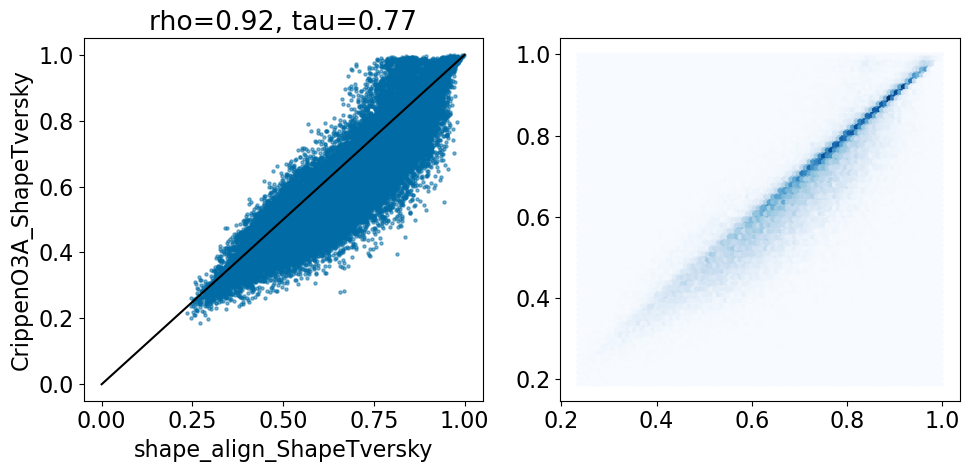

In [14]:
comparison_plot(pairstats,'shape_align_ShapeTversky','CrippenO3A_ShapeTversky',invert1=False,invert2=False,
                includeLine=True)

This looks quite similar to the last results, but this time we don't have failed alignments due to missing atom types.

Compare the two different Open3DAlign results to each other:

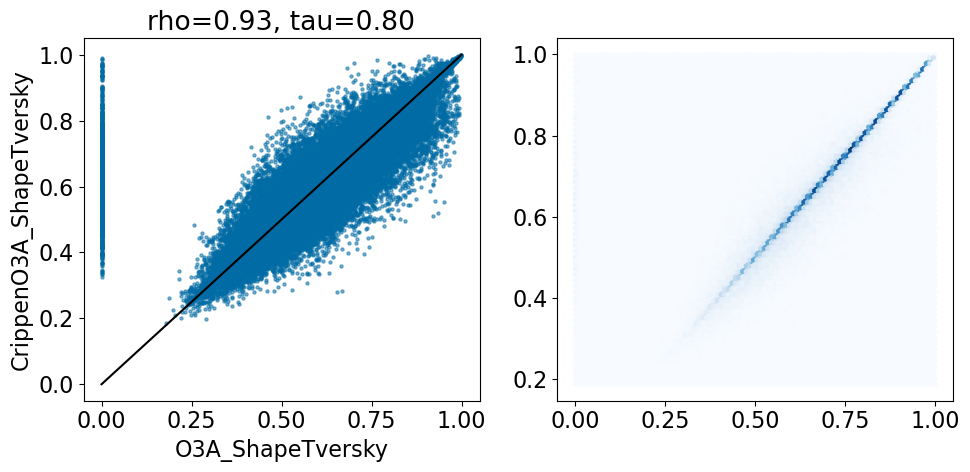

In [15]:
comparison_plot(pairstats,'O3A_ShapeTversky','CrippenO3A_ShapeTversky',invert1=False,invert2=False,
                includeLine=True)

And, finally, compare the Crippen O3A results to the crystal alignments:

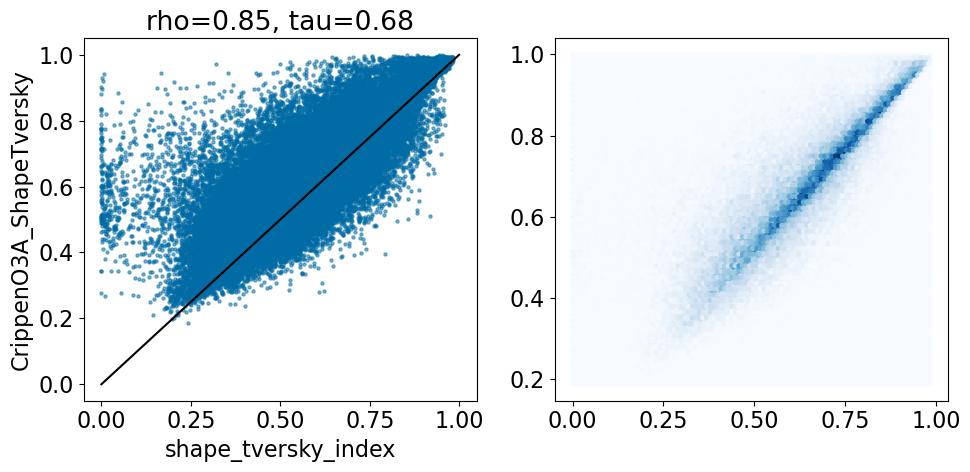

In [16]:
comparison_plot(pairstats,'shape_tversky_index','CrippenO3A_ShapeTversky',invert1=False,invert2=False,
                includeLine=True)

# Comparing performance on "easy" cases

The LOBSTER paper suggests that ligand pairs that have a Tversky overlap of 0.9 or higher are good starting points for studying superposition algorithms.

Let's see how well the three alignment approaches we applied here do:

In [45]:
pruned = [r for r in pairstats if r['shape_tversky_index']>=0.9]
len(pruned)


2653

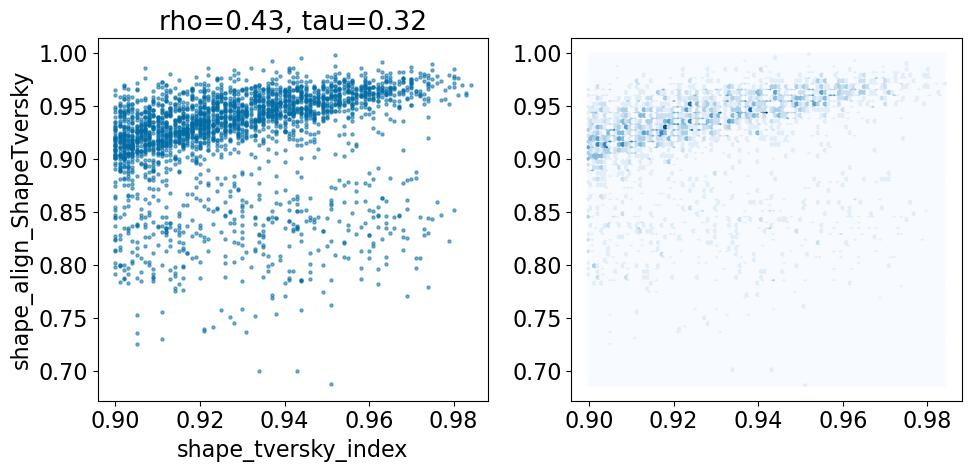

In [47]:
comparison_plot(pruned,'shape_tversky_index','shape_align_ShapeTversky',invert1=False,invert2=False)

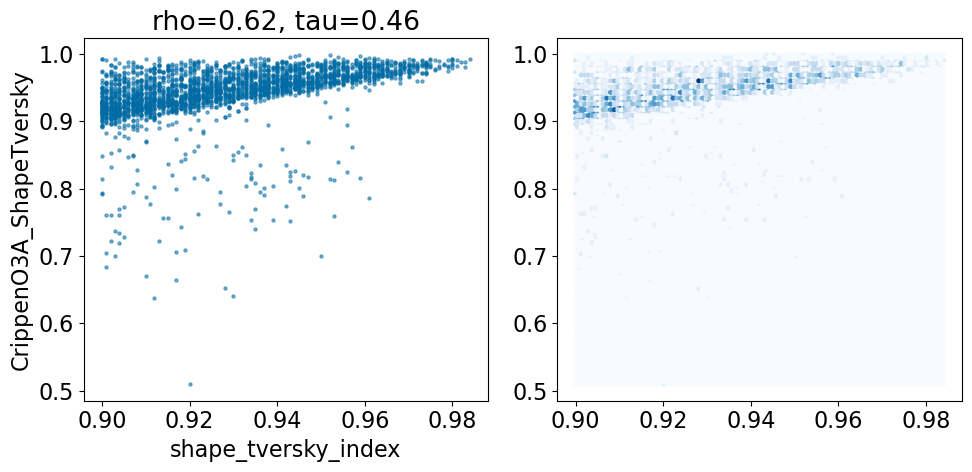

In [50]:
comparison_plot(pruned,'shape_tversky_index','CrippenO3A_ShapeTversky',invert1=False,invert2=False)

Make the same plot with the default O3A alignments that did not fail due to missing parameters:

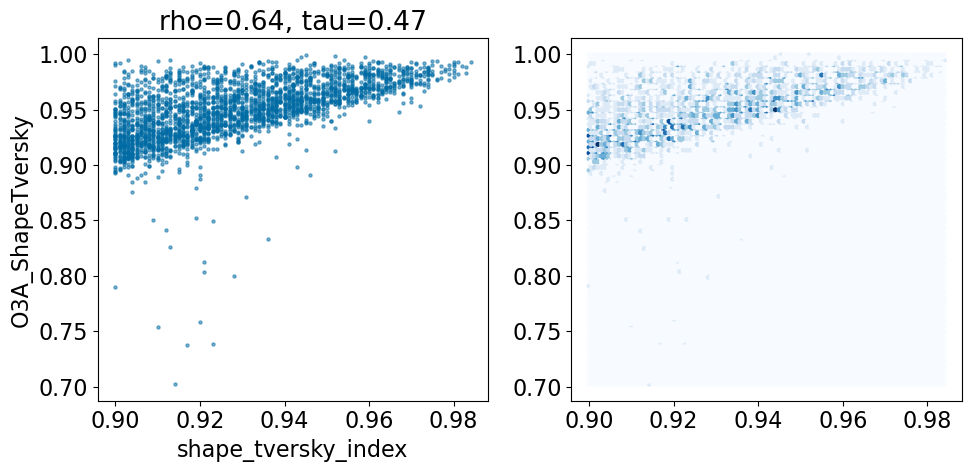

In [51]:
comparison_plot([x for x in pruned if x['O3A_ShapeTversky']>0],'shape_tversky_index','O3A_ShapeTversky',invert1=False,invert2=False)

Here's what that looks like with the failed alignments included:

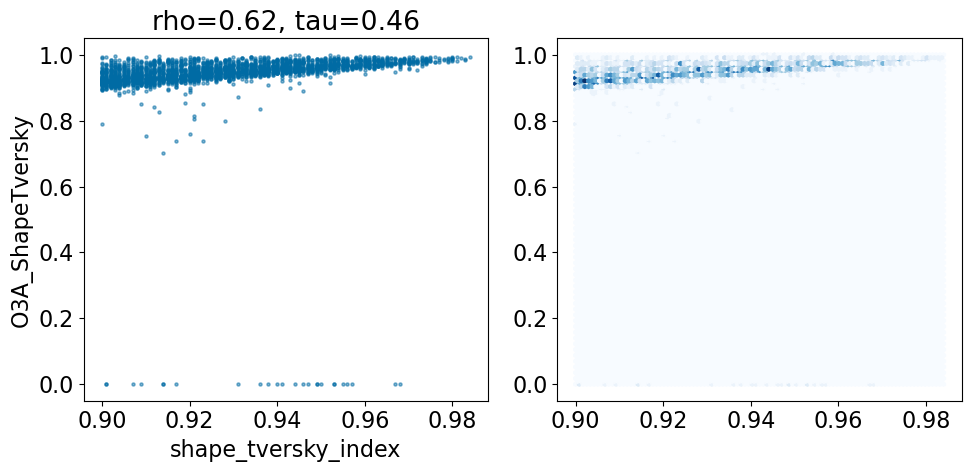

In [49]:
comparison_plot(pruned,'shape_tversky_index','O3A_ShapeTversky',invert1=False,invert2=False)

Based on this simple analysis, it looks like the Open3DAlign methods are doing better than the shape-based alignment. Given the differences in size between some of the ligands, this isn't terribly surprising.

To really dig into alignment quality, we'd probably also want to look beyond just shape overlap and considere things like how far the aligned poses are from what is observed in the crystal using some kind of RMSD measure, but that's for a possible future post.